# Build Sequence Model

In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from lightgbm import LGBMRegressor
from sklearn.base import clone
from sklearn.metrics import r2_score
import sglearn
import optuna
from joblib import Parallel, delayed
import numpy as np
from datetime import datetime

from datasets import dataset_list
from core import (get_predictive_performance,
                  plot_spearman_heatmap,
                  plot_model_performance,
                  setup_plots)

In [2]:
setup_plots()

In [3]:
def train_test_model(train_df, model_name, fold, model, test_df, X_test):
    """Get predictions from train and test model

    :param train_df: DataFrame
    :param model_name: str, name of model
    :param fold: int
    :param model: model with a .fit function
    :param test_df: DataFrame
    :param X_test: DataFrame from sglearn.featurize_guides
    :return: DataFrame, same shape as test_df with columns prediction, model, fold
    """
    X_train = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train = train_df['sgRNA Activity']
    model.fit(X_train,  y_train)
    dataset_test_predictions = test_df.copy()
    dataset_test_predictions['prediction'] = model.predict(X_test)
    dataset_test_predictions['model_name'] = model_name
    dataset_test_predictions['fold'] = fold
    return dataset_test_predictions


def get_fold_predictions(fold, fold_df,
                         base_model=LGBMRegressor(random_state=7, n_jobs=8),
                         top_training_set=None, combine_datasets=None, model_name=None):
    """Get predictions for a given fold, allowing for each dataset to be trained separately,
    or multiple datasets trained together

    :param fold: int
    :param fold_df: DataFrame
    :param base_model: model with a .fit function
    :param top_training_set: str
    :param combine_datasets: list of
    :param model_name: str optional, only relevant if top_datasets is specified
    :return: list of DataFrame, list of test predictions
    """
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    test_prediction_list = []
    if combine_datasets is None:
        for dataset, dataset_df in fold_train_data.groupby('dataset'):
            dataset_df = dataset_df.reset_index(drop=True)
            # Join together top training set and current dataset
            if top_training_set is not None:
                if dataset != top_training_set:
                    top_dataset_df = fold_train_data[fold_train_data.dataset == top_training_set]
                    dataset_df = pd.concat([dataset_df, top_dataset_df]).reset_index(drop=True)
                    dataset_df['sgRNA Activity'] = (dataset_df.groupby('dataset')
                                                    ['sgRNA Activity']
                                                    .rank(pct=True))
                    dataset += ' + ' + top_training_set  # For model_name
            model = clone(base_model)
            dataset_test_predictions = train_test_model(dataset_df, dataset, fold, model, fold_test_data, X_test)
            test_prediction_list.append(dataset_test_predictions)
    else:
        train_df = fold_train_data[fold_train_data.dataset.isin(combine_datasets)].reset_index(drop=True)
        train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                      ['sgRNA Activity']
                                      .rank(pct=True))
        model = clone(base_model)
        if model_name is None:
            model_name = ' + '.join(combine_datasets)
        dataset_test_predictions = train_test_model(train_df, model_name, fold,
                                                    model, fold_test_data, X_test)
        # For consistency we return a list of len 1
        test_prediction_list.append(dataset_test_predictions)
    return test_prediction_list

In [4]:
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()

In [5]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()

## Cross-Validation Iterator

We'll use [StratifiedGroupKFold](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html#sklearn.model_selection.StratifiedGroupKFold)

>This cross-validation object is a variation of StratifiedKFold attempts to return stratified folds with
> non-overlapping groups. The folds are made by preserving the percentage of samples for each class.

>The same group will not appear in two different folds (the number of distinct groups has to be at least equal to
> the number of folds).

>The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such
> that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to
> create folds which preserve the percentage of samples for each class as much as possible given the
> constraint of non-overlapping groups between splits.

In our case, we define each dataset as a "class", such that the datasets are approximately equally distributed across
folds, constrained by the notion that each "group" or gene cannot appear in both the train and test set in a given fold.

First, we assign sgRNAs to genes, capitalizing gene-names from the mouse libraries, so they overlap with the human annotations.
We can see that every context sequence uniquely targets a gene in this dataset

We assign context sequences without a group to their own group. Every dataset appears as both a training and testing
dataset in every fold, except Doench2014_human Doench2014_mouse, which have fewer than 5 genes

In [6]:
sg_df_list = []
for ds in train_data_list:
    sg_df = ds.get_sg_df(include_group=True, include_activity=True)
    sg_df['dataset'] = ds.name
    sg_df_list.append(sg_df)
sg_df_groups = (pd.concat(sg_df_list)
                .groupby(['sgRNA Context Sequence'])
                .agg(n_conditions = ('sgRNA Context Sequence', 'count'),
                     target = ('sgRNA Target', lambda x: ', '.join(set([s.upper() for s in x if not pd.isna(s)]))))
                .reset_index())
multi_target = sg_df_groups['target'].str.contains(',').sum()
print('Context sequences with multiple targets: ' + str(multi_target))

Context sequences with multiple targets: 0


In [7]:
# handle singleton case
sg_df_groups['target'] = sg_df_groups.apply(lambda row:
                                            row['target'] if (row['target'] != '') else row['sgRNA Context Sequence'],
                                            axis=1)
# Note that 'target' is not in the sg_df_list, and is coming from the sg_df_groups df
sg_df_class_groups = (pd.concat(sg_df_list)
                      .merge(sg_df_groups, how='inner', on='sgRNA Context Sequence')
                      .sort_values(['dataset', 'target'])
                      .reset_index(drop=True))
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
tidy_cv_list = []
for i, (train_index, test_index) in enumerate(sgkf.split(sg_df_class_groups, sg_df_class_groups.dataset,
                                                         sg_df_class_groups.target)):
    train_df = sg_df_class_groups.iloc[train_index,:].copy()
    train_df['cv'] = i
    train_df['train'] = True
    tidy_cv_list.append(train_df)
    test_df = sg_df_class_groups.iloc[test_index,:].copy()
    test_df['cv'] = i
    test_df['train'] = False
    tidy_cv_list.append(test_df)
tidy_cv_df = pd.concat(tidy_cv_list)
cv_train_data_counts = (tidy_cv_df[['cv', 'train', 'dataset']].value_counts()
                        .reset_index(name='n'))
cv_train_data_counts

,cv,train,dataset,n
0,3,True,Kim2019_train,10939
1,4,True,Kim2019_train,10613
2,0,True,Kim2019_train,9958
3,1,True,Kim2019_train,9956
4,2,True,Kim2019_train,9862
5,0,True,Xiang2021,9183
6,1,True,Xiang2021,9137
7,4,True,Xiang2021,9137
8,2,True,Xiang2021,9068
9,3,True,Xiang2021,9063


In [8]:
(cv_train_data_counts[['cv', 'dataset']]
 .value_counts()
 .reset_index(name='n'))

,cv,dataset,n
0,0,Doench2014_human,2
1,2,Doench2014_mouse,2
2,4,Wang2014,2
3,4,Kim2019_train,2
4,4,Doench2016,2
5,4,Doench2014_mouse,2
6,3,Xiang2021,2
7,3,Wang2014,2
8,3,Kim2019_train,2
9,2,Xiang2021,2


The size of the training and testing sets are approximately equal across folds,
with training sets varying between 13,107 (fold 2) - 15,847 (fold 3) sgRNAs and testing sets varying
between 2,707 (fold 3) - 5,447 (fold 2) sgRNAs


In [9]:
(tidy_cv_df[['cv','train']].value_counts()
 .reset_index(name='n')
 .sort_values(['cv', 'train']))

,cv,train,n
7,0,False,6704
2,0,True,23247
5,1,False,6813
4,1,True,23138
6,2,False,6790
3,2,True,23161
9,3,False,4445
0,3,True,25506
8,4,False,5199
1,4,True,24752


Indeed each gene target (gene) only appears in one set in each fold

In [10]:
(tidy_cv_df[['cv','train', 'target']].value_counts()
 .reset_index(name='n')
 .query('n > 10')
 [['cv', 'target']].value_counts()
 .reset_index(name='train_test_sum')
 .groupby('cv')
 .agg({'train_test_sum': ['max']}))

,train_test_sum
,max
cv,
0,1
1,1
2,1
3,1
4,1


## Train each dataset separately
Now we'll move onto training and first we'll train each dataset separately

In [11]:
single_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    single_test_prediction_list.extend(get_fold_predictions(fold, df))
    print('\n')

single_predictive_performance, single_agg_perforamnce = get_predictive_performance(single_test_prediction_list,
                                                                                   'sgRNA Activity')

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




Importantly, all training datasets are successful at predicting held-out test data

In [12]:
single_agg_perforamnce

,model_name,mean_spearman,std_spearman,median_spearman
0,Kim2019_train,0.598962,0.118513,0.580739
1,Xiang2021,0.593959,0.133138,0.581159
2,Wang2014,0.449249,0.094417,0.480599
3,Doench2016,0.432238,0.060401,0.433995
4,Doench2014_mouse,0.427769,0.071951,0.424791
5,Doench2014_human,0.390378,0.121917,0.410418


/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_heatmap_single.pdf


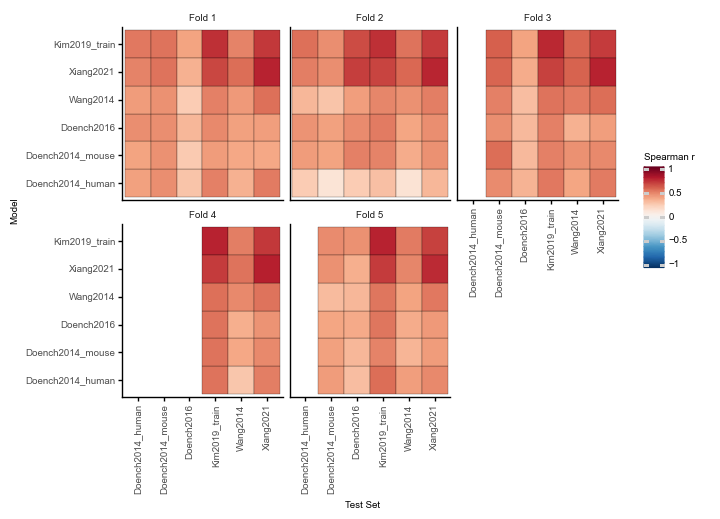

<ggplot: (8777897577093)>

In [13]:
g = plot_spearman_heatmap(single_predictive_performance)
g.save('../figures/seq_heatmap_single.pdf', width=3.5, height=2.2)
g

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.75 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_point_single.pdf


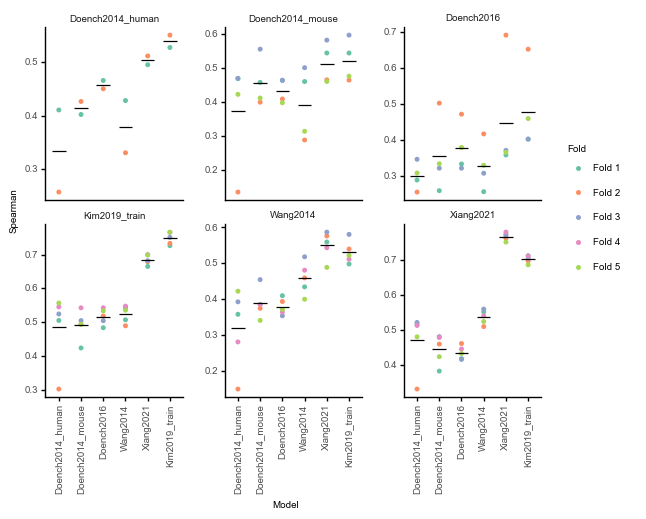

<ggplot: (8777889780149)>

In [14]:
g = plot_model_performance(single_predictive_performance)
g.save('../figures/seq_point_single.pdf', width=3.75, height=2.2)
g

## Combining training datasets

If we merge the training datasets, can we improve our performance?
We'll merge by normalizing activity to a percent rank.

In [15]:
top_training_set = single_agg_perforamnce['model_name'][0]
print('Top training set: ' + top_training_set)

Top training set: Kim2019_train


In [16]:
combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: '+ str(fold))
    combined_test_prediction_list.extend(get_fold_predictions(fold, df, top_training_set=top_training_set))
    print('\n')

combined_predictive_performance, combined_agg_performance = get_predictive_performance(combined_test_prediction_list,
                                                                                       'sgRNA Activity')

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4




In [17]:
combined_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,Xiang2021 + Kim2019_train,0.626278,0.125145,0.610297
1,Doench2014_mouse + Kim2019_train,0.607496,0.112705,0.587731
2,Wang2014 + Kim2019_train,0.601700,0.118059,0.575536
3,Doench2014_human + Kim2019_train,0.600793,0.115303,0.580152
4,Doench2016 + Kim2019_train,0.599053,0.111202,0.570188
5,Kim2019_train,0.598962,0.118513,0.580739


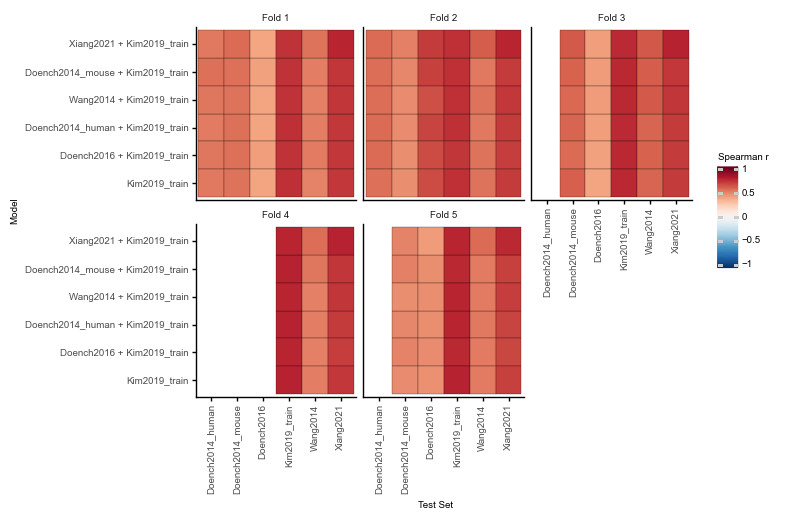

<ggplot: (8777851191372)>

In [18]:
plot_spearman_heatmap(combined_predictive_performance)

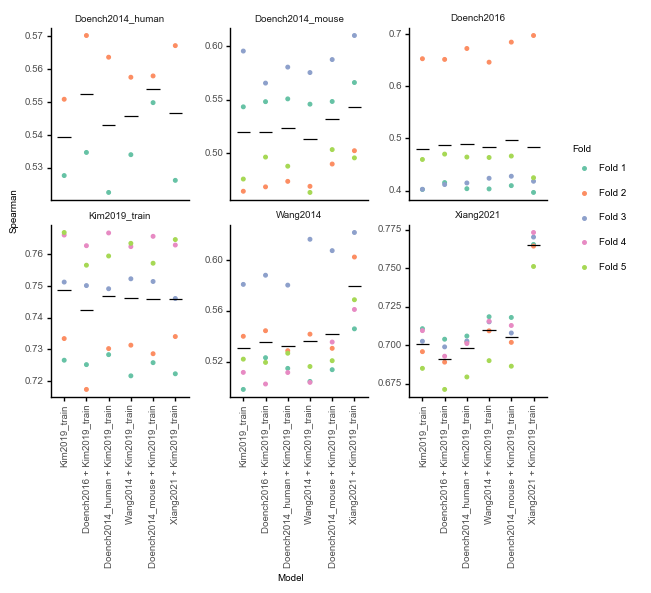

<ggplot: (8777851028983)>

In [19]:
plot_model_performance(combined_predictive_performance)

We'll combine all training sets since none decrease performance

In [20]:
combine_datasets =  list(single_agg_perforamnce['model_name'])

In [21]:
top_combined_test_prediction_list = []
for fold, df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    top_combined_test_prediction_list.extend(get_fold_predictions(fold, df, combine_datasets=combine_datasets,
                                                                  model_name='All train data'))
    print('\n')

print('Reference model: ' + str(top_training_set))
top_training_prediction_list = [df for df in single_test_prediction_list if (df.model_name == top_training_set).all()]
top_combined_predictive_performance, top_combined_agg_performance = get_predictive_performance(
    top_combined_test_prediction_list + top_training_prediction_list, 'sgRNA Activity')

Fold: 0


Fold: 1


Fold: 2


Fold: 3


Fold: 4


Reference model: Kim2019_train


In [22]:
top_combined_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All train data,0.629660,0.119261,0.618695
1,Kim2019_train,0.598962,0.118513,0.580739


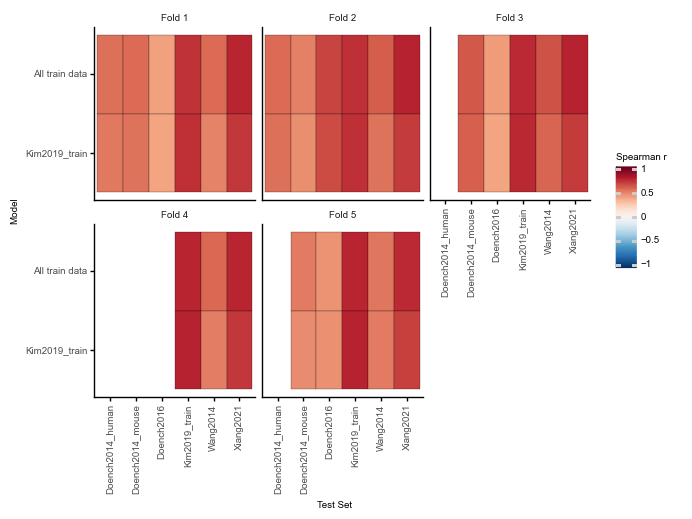

<ggplot: (8777888630595)>

In [23]:
plot_spearman_heatmap(top_combined_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_combined_model_performance.pdf


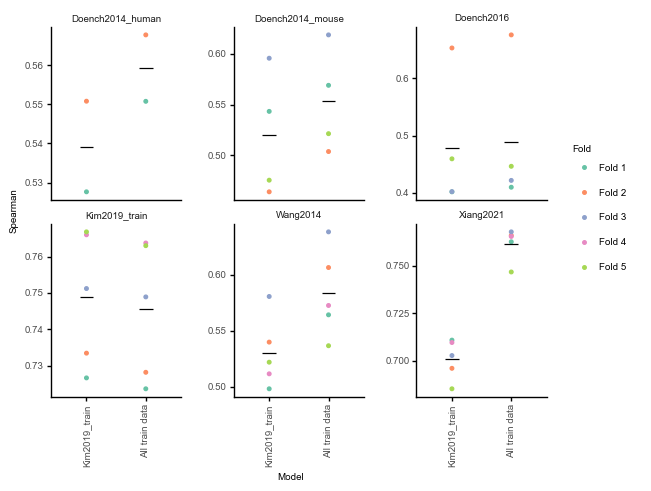

<ggplot: (8777884370704)>

In [24]:
g = plot_model_performance(top_combined_predictive_performance, wspace=0.4)
g.save('../figures/seq_combined_model_performance.pdf', width=3.5, height=2.2)
g

## Sequence Model Hyperparameter Tuning

Using the combined datasets, we'll try different model architectures and use hyperparameter tuning.
For the hyperparmeter tuning, we'll use the [optuna library](https://optuna.readthedocs.io/en/stable/index.html),
which by default uses the Tree-structured Parzen Estimator to search the hyperparameter space.

In [25]:
n_trials = 50

### LightGBM

In [26]:
def lgbm_training_iteration(fold_df, train_index, test_index, base_model):
    """Train lgbm model for optuna iterations

    :param fold_df: DataFrame
    :param train_index: list-like
    :param test_index: list-like
    :param base_model: LGBMRegressor
    :return: r^2
    """
    train_df = fold_df.iloc[train_index,:].reset_index(drop=True)
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence']) # train and validation data
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = clone(base_model)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=False)
    test_df = fold_df.iloc[test_index,:].reset_index(drop=True)
    X_test = sglearn.featurize_guides(test_df['sgRNA Context Sequence'])
    test_predictions = test_df.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['sgRNA Activity'] = (test_predictions.groupby('dataset')
                                          ['sgRNA Activity']
                                          .rank(pct=True))
    r2 = r2_score(test_predictions['sgRNA Activity'], test_predictions['prediction'])
    return r2


def get_lgbm_objective(fold_df):
    """Get objective function for training a lgbm model

    :param fold_df: DataFrame
    :return: obejctive function
    """
    def objective(trial):
        """For training set, get optimal hyperparameters for lgbm

        :param trial: optuna.trial
        :return: int, pearson correlation with held out test data
        """
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=7)
        num_leaves = trial.suggest_int('num_leaves', 8, 256)
        min_child_samples = trial.suggest_int('min_child_samples', 8, 256)
        model = LGBMRegressor(random_state=7, n_jobs=1, learning_rate=0.01, n_estimators=5000,
                              num_leaves=num_leaves,
                              min_child_samples=min_child_samples)
        performance = Parallel(n_jobs=5)(delayed(lgbm_training_iteration)
                                         (fold_df, train_index, test_index, model) for
                                         train_index, test_index in
                                         sgkf.split(fold_df, fold_df.dataset, fold_df.target))
        avg_performance = np.mean(performance)
        return avg_performance
    return objective

In [ ]:
lgbm_prediction_list = []

for fold, fold_df in tidy_cv_df.groupby('cv'):
    print('Fold: ' + str(fold))
    fold_train_data = fold_df.query('train == True').reset_index(drop=True)
    study = optuna.create_study(direction='maximize',
                                sampler=optuna.samplers.TPESampler(seed=7)) # maximize r^2
    objective = get_lgbm_objective(fold_train_data)
    start_time = datetime.now()
    study.optimize(objective, n_trials=n_trials)
    end_time = datetime.now()
    difference = end_time - start_time
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Training Time: " + str(difference))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    # Using optimal parameters, retrain model with full dataset
    train_df = fold_train_data.copy()
    train_df['sgRNA Activity'] = (train_df.groupby('dataset')
                                  ['sgRNA Activity']
                                  .rank(pct=True))
    X_train_val = sglearn.featurize_guides(train_df['sgRNA Context Sequence'])
    y_train_val = train_df['sgRNA Activity']
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=0.1, random_state=7)
    model = LGBMRegressor(random_state=7, n_jobs=8, learning_rate=0.01, n_estimators=5000,
                          **trial.params)
    model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_val, y_val)], verbose=1000)
    # Test optimal model on test data
    fold_test_data = fold_df.query('train == False').reset_index(drop=True)
    X_test = sglearn.featurize_guides(fold_test_data['sgRNA Context Sequence'])
    test_predictions = fold_test_data.copy()
    test_predictions['prediction'] = model.predict(X_test)
    test_predictions['model_name'] = 'All + LGBM + TPE' + str(n_trials)
    test_predictions['fold'] = fold
    lgbm_prediction_list.append(test_predictions)

[I 2021-06-03 15:22:46,209] A new study created in memory with name: no-name-d7bb8edf-7b3d-4001-b7c9-0c4760aaf832


Fold: 0


In [ ]:
lgbm_predictive_performance, lgbm_agg_performance = get_predictive_performance(
    top_combined_test_prediction_list + lgbm_prediction_list, 'sgRNA Activity')

In [ ]:
plot_spearman_heatmap(lgbm_predictive_performance)

In [ ]:
g = plot_model_performance(lgbm_predictive_performance, wspace=0.45)
g.save('../figures/seq_lgbm_tpe_model_performance.pdf', width=3.5, height=2.2)
g


### CNN

In [31]:
cnn_predictions = pd.read_csv('../data/external/seq_cnn_predictions.csv')
cnn_prediction_list = [cnn_predictions]

In [32]:
cnn_lgbm_predictive_performance, cnn_lgbm_agg_performance = get_predictive_performance(
    cnn_prediction_list + lgbm_prediction_list, 'sgRNA Activity')

In [33]:
cnn_lgbm_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All + LGBM + TPE50,0.575811,0.118331,0.566353
1,All + CNN + TPE50,0.569994,0.118906,0.557304


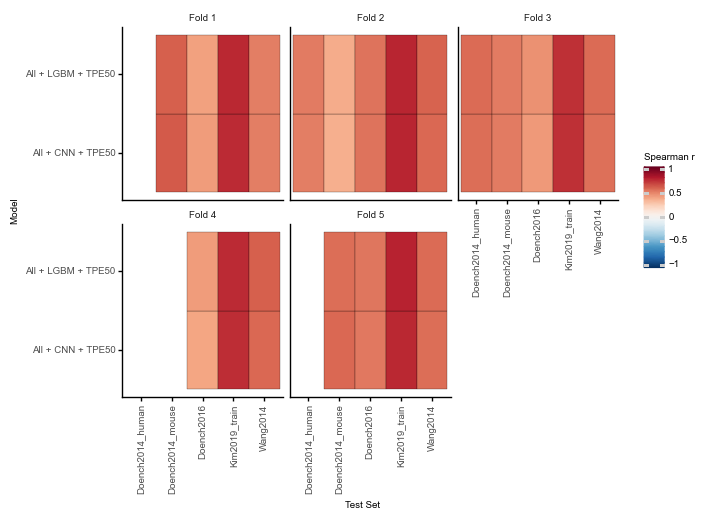

<ggplot: (8773629843143)>

In [34]:
plot_spearman_heatmap(cnn_lgbm_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3.5 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_cnn_lgbm_predictive_performance.pdf


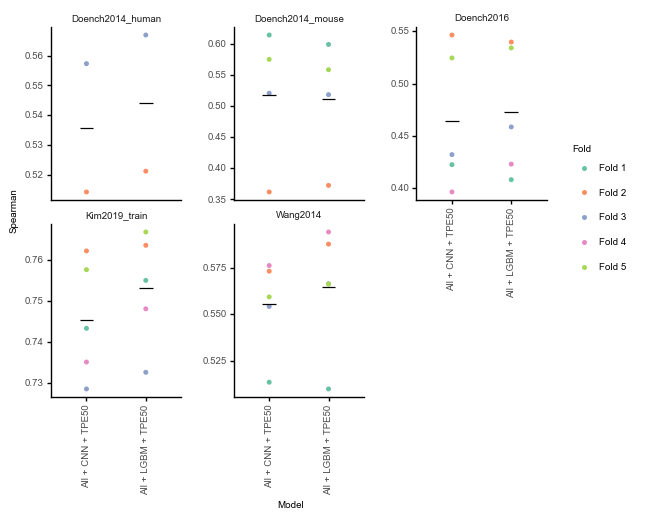

<ggplot: (8773629952398)>

In [35]:
g = plot_model_performance(cnn_lgbm_predictive_performance, wspace=0.4)
g.save('../figures/seq_cnn_lgbm_predictive_performance.pdf', width=3.5, height=2.2)
g

### All Models

In [36]:
all_predictive_performance, all_agg_performance = get_predictive_performance(
    single_test_prediction_list + top_combined_test_prediction_list + lgbm_prediction_list + cnn_prediction_list,
    'sgRNA Activity')

In [37]:
all_agg_performance

,model_name,mean_spearman,std_spearman,median_spearman
0,All + LGBM + TPE50,0.575811,0.118331,0.566353
1,All + CNN + TPE50,0.569994,0.118906,0.557304
2,All train data,0.564910,0.119909,0.545445
3,Kim2019_train,0.554728,0.132423,0.546507
4,Doench2016,0.415517,0.070972,0.405395
5,Wang2014,0.412837,0.100522,0.409318
6,Doench2014_mouse,0.387962,0.079485,0.391677
7,Doench2014_human,0.374053,0.101959,0.336841


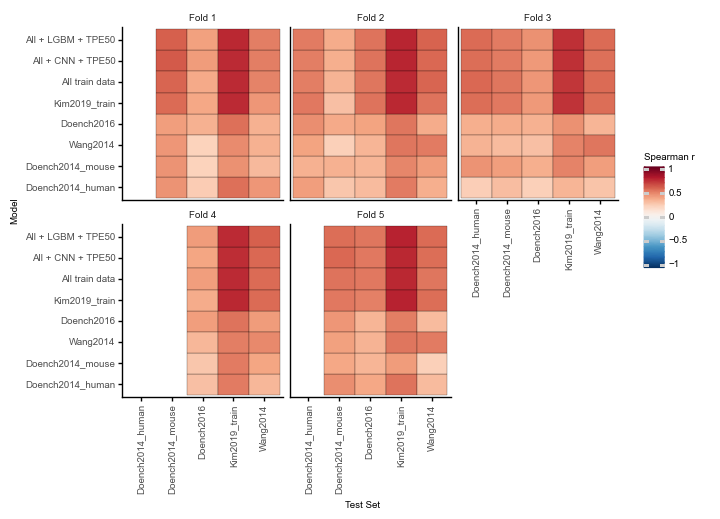

<ggplot: (8773518999089)>

In [38]:
plot_spearman_heatmap(all_predictive_performance)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 7 x 2.2 in image.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../figures/seq_all_performance.pdf


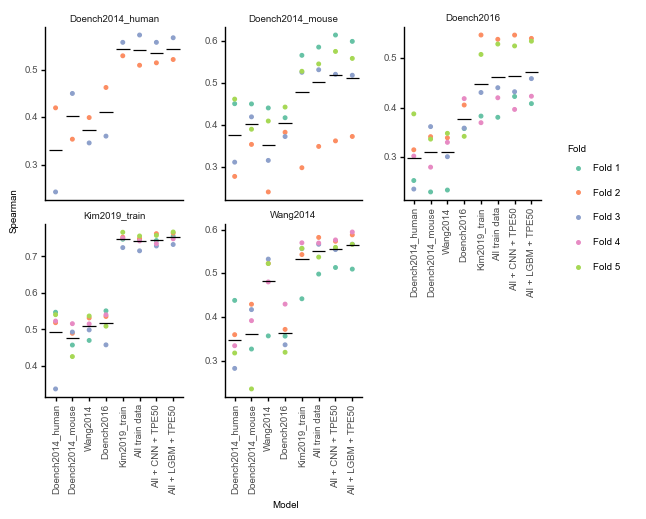

<ggplot: (8773604388711)>

In [39]:
g = plot_model_performance(all_predictive_performance)
g.save('../figures/seq_all_performance.pdf', width=7, height=2.2)
g